In [14]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [15]:
# Load and preprocess the dataset
data_path = 'ckextended.csv' 
data = pd.read_csv(data_path)
X = []
y = []


In [16]:
for i, row in data.iterrows():
    pixel_data = row['pixels']
    if isinstance(pixel_data, str):  # Validate that pixel data is a string
        pixels = list(map(int, pixel_data.split(' ')))
        if len(pixels) == 48 * 48:  # Ensure the pixel data is of correct length
            image = np.array(pixels).reshape(48, 48).astype(np.uint8)
            if image is not None and image.size > 0:
                image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_CUBIC)
                X.append(image)
                y.append(row['emotion'])
            else:
                print(f"Skipping image {i}: Invalid image data")
        else:
            print(f"Skipping row {i}: Pixel data length is {len(pixels)} instead of 48x48.")
    else:
        print(f"Skipping row {i}: Pixel data is not valid.")


In [17]:
# Convert lists to NumPy arrays for model training
X = np.array(X)
y = np.array(y)

# Normalize and reshape for the model
X = np.expand_dims(X, axis=-1)
X = np.repeat(X, 3, axis=-1)  # Convert grayscale to RGB
X = X / 255.0  # Normalize the pixel values


In [18]:
# Define emotion dictionary
emotion_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
# Filter out any samples where the label is not in the range 0-6
valid_indices = [i for i, label in enumerate(y) if label in emotion_dict]
X = np.array([X[i] for i in valid_indices])
y = np.array([y[i] for i in valid_indices])

# Print shapes for debugging
print("Final X shape:", X.shape)
print("Final y shape:", y.shape)


Final X shape: (902, 224, 224, 3)
Final y shape: (902,)


In [19]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def preprocess_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

def create_dataset(images, labels, batch_size, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(images))
        dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [20]:

# Create datasets
batch_size = 32
train_dataset = create_dataset(X_train, y_train, batch_size)
test_dataset = create_dataset(X_test, y_test, batch_size, is_training=False)


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the AlexNet model architecture
def create_alexnet(input_shape):
    model = Sequential()
    
    # First Convolutional Layer
    model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape, padding='valid'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())
    
    # Second Convolutional Layer
    model.add(Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())
    
    # Third Convolutional Layer
    model.add(Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))
    
    # Fourth Convolutional Layer
    model.add(Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))
    
    # Fifth Convolutional Layer
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())
    
    # Flatten the output
    model.add(Flatten())
    
    # Fully connected layers
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer
    model.add(Dense(7, activation='softmax'))  # Assuming 7 classes
    
    return model

# Input shape for the AlexNet model: 224x224 images with 3 channels (RGB)
input_shape = (224, 224, 3)

# Create the AlexNet model
alexnet_model = create_alexnet(input_shape)

# Compile the model
alexnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
alexnet_model.summary()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 26, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │        28,679 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,778,119 (178.44 MB)

 Trainable params: 46,776,903 (178.44 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [22]:
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the model
history = alexnet_model.fit(train_dataset, 
                           epochs=50, 
                           validation_data=test_dataset,
                           callbacks=[early_stopping, lr_reduction])


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 807ms/step - accuracy: 0.4386 - loss: 7.3937 - val_accuracy: 0.0829 - val_loss: 33.5732 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 785ms/step - accuracy: 0.5604 - loss: 1.7585 - val_accuracy: 0.6740 - val_loss: 5.2267 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 761ms/step - accuracy: 0.5900 - loss: 1.6264 - val_accuracy: 0.6740 - val_loss: 2.3531 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 771ms/step - accuracy: 0.6343 - loss: 1.4570 - val_accuracy: 0.4088 - val_loss: 1.6896 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 883ms/step - accuracy: 0.5798 - loss: 1.5741 - val_accuracy: 0.6740 - val_loss: 1.7859 - learning_rate: 0.0010
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 802ms/step - accuracy: 0.6469 - loss: 1.4456 - val_accuracy: 0.6740 - val_loss: 1.5855 - learning_rate: 0.0010
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 782ms/step - accuracy: 0.6455 - loss: 1

In [23]:
# Evaluate the model on test data
test_loss, test_acc = alexnet_model.evaluate(test_dataset)
print(f'Test Accuracy: {test_acc:.4f}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.8132 - loss: 0.5902
Test Accuracy: 0.8398


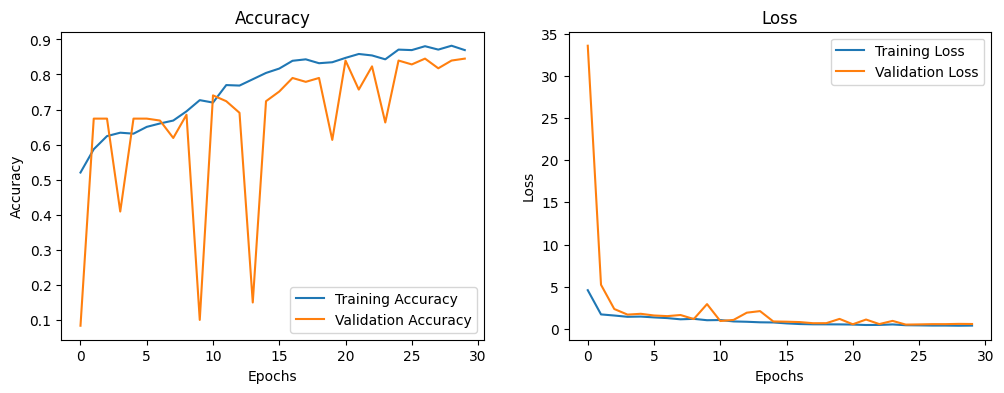

In [24]:
# Plot the training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot training history
plot_training_history(history)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


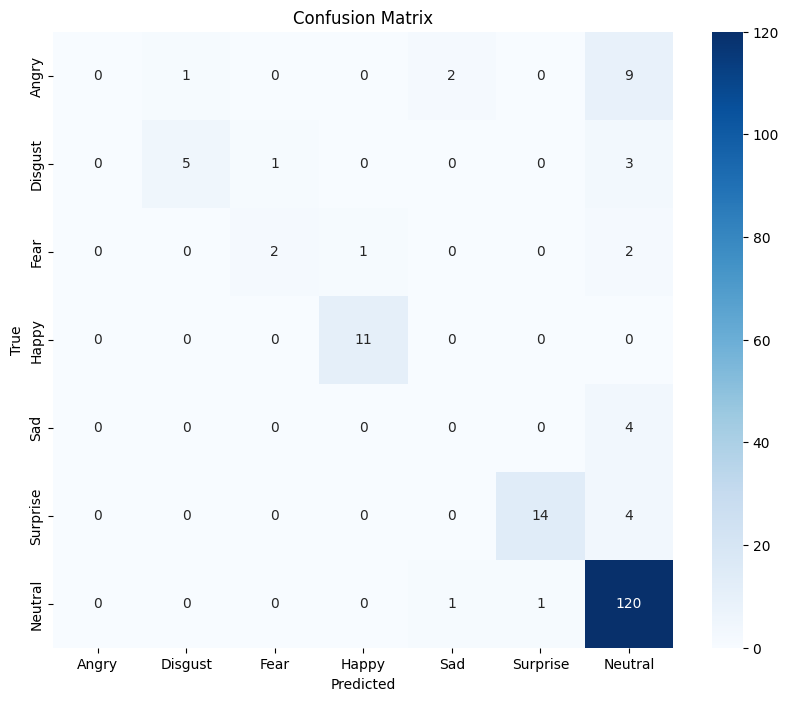

Classification Report:
               precision    recall  f1-score   support

       Angry       0.00      0.00      0.00        12
     Disgust       0.83      0.56      0.67         9
        Fear       0.67      0.40      0.50         5
       Happy       0.92      1.00      0.96        11
         Sad       0.00      0.00      0.00         4
    Surprise       0.93      0.78      0.85        18
     Neutral       0.85      0.98      0.91       122

    accuracy                           0.84       181
   macro avg       0.60      0.53      0.55       181
weighted avg       0.78      0.84      0.80       181



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [25]:
# Predict the labels for the test dataset
y_pred_probs = alexnet_model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the predicted class labels

# Get the true labels from the test dataset
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_dict.values(), yticklabels=emotion_dict.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report for detailed metrics
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=emotion_dict.values()))

In [26]:
alexnet_model.save("alexnet302.h5")